# Лабораторная работа №4
# Линейные модели, SVM и деревья решений.

Выполнил: **Пакало А. С., РТ5-61Б**

## Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
1. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
1. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
1. Обучите следующие модели:
  - одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации);
  - SVM;
  - дерево решений.
1. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
1. Постройте график, показывающий важность признаков в дереве решений.
1. Визуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

## Текстовое описание набора данных
Для обучения моделей был выбран набор данных по недельным продажам в сети
магазинов Walmart ([Walmart Dataset](https://www.kaggle.com/datasets/yasserh/walmart-dataset)). На основе данного датасета будем решать задачу регресии.

В данном наборе данных присутствуют следующие столбцы:

* Store — номер магазина;
* Date — дата начала недели продаж;
* Weekly_Sales — недельные продажи магазина. Является целевым признаком;
* Holiday_Flag — бинарный признак отсутствия/наличния (0/1) праздника;
* Temperature — температура в день продаж;
* Fuel_Price — цена топлива в регионе;
* [CPI](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%BF%D0%BE%D1%82%D1%80%D0%B5%D0%B1%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D1%85_%D1%86%D0%B5%D0%BD) — индекс потребительских цен;
* Unemployment — показатель безработицы.

Так как данных очень много, перед тем как приступить к анализу, проведем обзор данных и, возможно, потребуется их предобработка, чтобы датасет стал более удобным и пригодным к проведению исследования.

Таким образом исследование пройдет в 6 этапов:
- загрузка данных,
- проведение разведочного анализа данных и предобработка данных,
- разделение на обучающую и тестовую выборку,
- выбор метрики,
- обучение моделей,
- сравнение значений метрики.

## Импортирование необходимых библиотек, подготовка окружения

In [1]:
# Основные библиотеки.
from IPython.core.display import display_markdown
import numpy as np
import pandas as pd

# Визуализция.
import matplotlib.pyplot as plt
import seaborn as sns

# Для разбития выборки.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Отрисовка статуса выполнения.
from tqdm.notebook import tqdm

# Типизация.
from typing import List

# Вывод данных.
from IPython.display import display


# Конфигурация визуализации.
%matplotlib inline
sns.set(style='ticks')

## Загрузка данных
### Считываем данные из .csv
Загрузим файлы датасета в помощью библиотеки Pandas.

Не смотря на то, что файлы имеют расширение txt они представляют собой данные
в формате [CSV](https://ru.wikipedia.org/wiki/CSV). Часто в файлах такого
формата в качестве разделителей используются символы ",", ";" или табуляция.
Поэтому вызывая метод read_csv всегда стоит явно указывать разделитель данных
с помощью параметра sep. Чтобы узнать какой разделитель используется в файле
его рекомендуется предварительно посмотреть в любом текстовом редакторе.

In [2]:
walmart = pd.read_csv('data/Walmart.csv')

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и предобработка данных.

Размеры датасета: (строки, колонки).

In [3]:
walmart.shape

(6435, 8)

Общий вид данных таблицы:

In [4]:
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Список колонок:

In [5]:
walmart.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

Список колонок с типами данных:

In [6]:
walmart.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

Как видно, все данные приведены к адекватному типу данных.

Пустые значения:

In [7]:
walmart.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Пустых значений нет.

Проверим на дублирующиеся значения:

In [8]:
walmart.duplicated().sum()

0

Дублирующихся значений нет.

## Предобработка данных
С признаком, хранящий дату, будет легче работать, если разбить его на три
отдельные признака: неделя, месяц и год. Можем позволить оставить наименьшей
единицей неделю, так как нам даны лишь *недельные* продажи магазина.

In [9]:
# Разделение поля Date
walmart['Date'] = pd.to_datetime(walmart['Date'], dayfirst=True)
walmart['Week'] = walmart['Date'].dt.isocalendar().week.astype('int64')
walmart['Month'] = walmart['Date'].dt.month
walmart['Year'] = walmart['Date'].dt.year

# Удаление столбца Date
walmart = walmart.drop(columns=['Date'])

# Перестановка столбцов
walmart = walmart[['Store', 'Week', 'Month', 'Year', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']]
display(walmart.head(), walmart.dtypes)



,Store,Week,Month,Year,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,5,2,2010,0,42.31,2.572,211.096358,8.106,1643690.90
1,1,6,2,2010,1,38.51,2.548,211.242170,8.106,1641957.44
2,1,7,2,2010,0,39.93,2.514,211.289143,8.106,1611968.17
3,1,8,2,2010,0,46.63,2.561,211.319643,8.106,1409727.59
4,1,9,3,2010,0,46.50,2.625,211.350143,8.106,1554806.68


Store             int64
Week              int64
Month             int64
Year              int64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Weekly_Sales    float64
dtype: object

## Корреляционный анализ
Построим корреляционную матрицу, чтобы проанализировать зависимости
параметров.
Тепловая карта корреляционной матрицы.

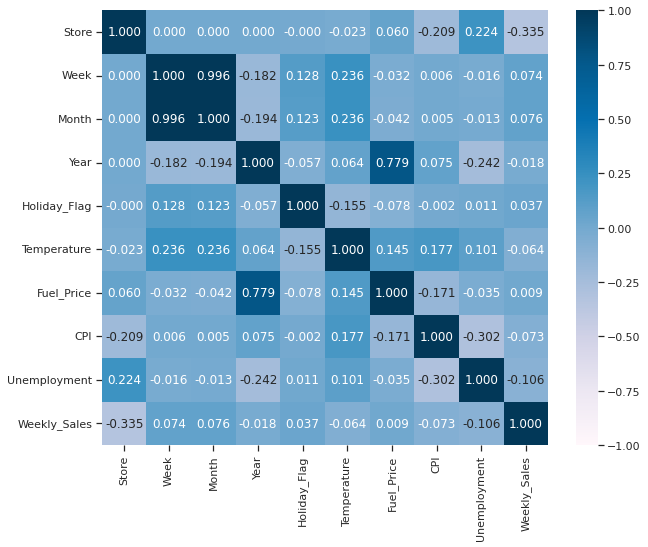

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(data=walmart.corr(), vmin=-1, vmax=1, annot=True, fmt='.3f',
            cmap='PuBu')
plt.show()

Из данной корреляционной матрицы можем сделать следующие выводы:

- Все нецелевые признаки имеют слабую связь с целевым (Weekly_Sales). Сильнее
всего коррилиует признак Store;
- Признаки Week и Month практически линейно зависимы друг от друга. Оставим
только признак Week;
- Признаки Year и Fuel_Price тоже сильно коррелируют друг с другом. Оставим
признак Fuel_Price.

In [11]:
# Удаление лишних колонок
walmart_without_linear_correlates = walmart.drop(columns=['Month', 'Year'])
walmart_without_linear_correlates.head()



,Store,Week,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,5,0,42.31,2.572,211.096358,8.106,1643690.90
1,1,6,1,38.51,2.548,211.242170,8.106,1641957.44
2,1,7,0,39.93,2.514,211.289143,8.106,1611968.17
3,1,8,0,46.63,2.561,211.319643,8.106,1409727.59
4,1,9,0,46.50,2.625,211.350143,8.106,1554806.68


In [12]:
# Извлекаем целевой признак.
TARGET_COL_NAMES = ['Weekly_Sales']
walmart_weekly_sales = walmart[TARGET_COL_NAMES]

walmart_features = walmart.drop(columns=TARGET_COL_NAMES)
display(walmart_weekly_sales, walmart_features)

,Weekly_Sales
0,1643690.90
1,1641957.44
2,1611968.17
3,1409727.59
4,1554806.68
...,...
6430,713173.95
6431,733455.07
6432,734464.36
6433,718125.53


,Store,Week,Month,Year,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,5,2,2010,0,42.31,2.572,211.096358,8.106
1,1,6,2,2010,1,38.51,2.548,211.242170,8.106
2,1,7,2,2010,0,39.93,2.514,211.289143,8.106
3,1,8,2,2010,0,46.63,2.561,211.319643,8.106
4,1,9,3,2010,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...,...
6430,45,39,9,2012,0,64.88,3.997,192.013558,8.684
6431,45,40,10,2012,0,64.89,3.985,192.170412,8.667
6432,45,41,10,2012,0,54.47,4.000,192.327265,8.667
6433,45,42,10,2012,0,56.47,3.969,192.330854,8.667


In [13]:
# Перед использованием модели закодируем категориальные признаки с помощью
# one-hot encoding, где каждое уникальное значение признака становится новым
# признаком. Это позволяет избежать фиктивного отношения порядка.

In [14]:
# categorical_pipeline = Pipeline([
    # ( 'one-hot', DataFrameOneHotEncoder(handle_unknown='ignore') )
# ])
# CATEGORICAL_COL_NAMES = ['Color', 'Spectral_Class']
# # Returns tuple: (2d-array with columns?, shape).
# caterogical_star_features = categorical_pipeline.fit_transform(walmart[CATEGORICAL_COL_NAMES]),
# caterogical_star_features = pd.DataFrame(caterogical_star_features[0])

Нам также потребуется масштабировать данные для адекватной работы моделей (и
линейные , и SVM работают лучше, если  признаки представлены в одном
масштабе).

In [15]:
preprocessor = Pipeline([
    ( 'scaler', MinMaxScaler(feature_range=(0, 1)) )
])


walmart_features_transformed = preprocessor.fit_transform(walmart_features)
# Массив переводим обратно в датафрейм.
walmart_features_transformed = pd.DataFrame(walmart_features_transformed,
                                            columns=walmart_features.columns)

## С использованием метода train_test_split разделите выборку на обучающую и тестовую.

In [16]:

walmart_features_train: pd.DataFrame
walmart_features_test: pd.DataFrame
walmart_weekly_sales_train: pd.Series
walmart_weekly_sales_test: pd.Series

# Параметр random_state позволяет задавать базовое значение для генератора
# случайных чисел. Это делает разбиение неслучайным. Если задается параметр
# random_state то результаты разбиения будут одинаковыми при различных
# запусках. На практике этот параметр удобно использовать для создания
# "устойчивых" учебных примеров, которые выдают одинаковый результат при
# различных запусках.
RANDOM_STATE_SEED = 1

walmart_features_train, walmart_features_test, walmart_weekly_sales_train, walmart_weekly_sales_test = train_test_split(
    walmart_features, walmart_weekly_sales, random_state=RANDOM_STATE_SEED)

Общий вид обучающей выборки:

In [17]:
from typing import Union
def display_df_shape(df: Union[pd.DataFrame, pd.Series]):
    display_markdown(
        f'- Кол-во рядов: {df.shape[0]}\n- Кол-во колонок: {df.shape[1]}',
        raw=True)


def display_split_result(split: Union[pd.DataFrame, pd.Series]):
    """Display result of the train_test_split.

    :param split: one of the splits to display.
    :type split: pd.DataFrame, pd.Series
    """

    display(split.head(1))
    display_df_shape(split)
    
    
display_split_result(walmart_features_train)
display_split_result(walmart_weekly_sales_train)

,Store,Week,Month,Year,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
2821,20,5,2,2012,0,39.93,3.617,213.023622,6.961


- Кол-во рядов: 4826
- Кол-во колонок: 9

,Weekly_Sales
2821,2203523.2


- Кол-во рядов: 4826
- Кол-во колонок: 1

Общий вид тестовой выборки:

In [18]:
display_split_result(walmart_features_test)
display_split_result(walmart_weekly_sales_test)

,Store,Week,Month,Year,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
447,4,23,6,2010,0,78.45,2.668,126.111903,7.896


- Кол-во рядов: 1609
- Кол-во колонок: 9

,Weekly_Sales
447,1870619.23


- Кол-во рядов: 1609
- Кол-во колонок: 1

## Выбор метрики
Для измерения качества моделей, решающих задачу линейной регрессии, будем
использовать следующие метрики:
- Средняя абсолютная ошибка (MAE),
- Средняя квадратичная ошибка (MSE),
- Коэффициент детерминации (R2).

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

scoring = (
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'r2',
)

def score(data_predicted, data_test):
    mae = mean_absolute_error(data_predicted, data_test)
    mse = mean_squared_error(data_predicted, data_test)
    r2 = r2_score(data_predicted, data_test)

    return {
        'mae': mae,
        'mse': mse,
        'r2': r2
    }


def display_score(scores):
    mae = scores.get('mae') or '---'
    mse = scores.get('mse') or '---'
    r2 = scores.get('r2') or '---'

    display_markdown(f'''
- Средняя абсолютная ошибка: {mae};
- Средняя квадратичная ошибка: {mse};
- Коэффициент детерминации: {r2}.
    ''', raw=True)

In [20]:
# Метрики будем складывать в этот словарь для дальнейшего сравнительного
#   анализа.
metrics_data = {}

def add_metrics_data(model_name, model_metric_data):
    metrics_data[model_name] = {}

    for metric_name, score in model_metric_data.items():
        metrics_data[model_name][metric_name] = score

# Обучение на основе моделей
## 1.1 Линейная регрессия

In [21]:
%%time
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()

linear_regression_pipeline = Pipeline([
    ( 'preprocess', preprocessor ),
    ( 'model', linear_regression ),
])

walmart_weekly_sales_predicted = linear_regression_pipeline.fit(walmart_features_train,
                   walmart_weekly_sales_train).predict(walmart_features_test)
linear_regression_score = score(walmart_weekly_sales_predicted, walmart_weekly_sales_test)
add_metrics_data('LinearRegression', linear_regression_score)
display_score(linear_regression_score)


- Средняя абсолютная ошибка: 440286.1632543231;
- Средняя квадратичная ошибка: 280148807533.08093;
- Коэффициент детерминации: -5.032226188224602.
    

CPU times: user 12.9 ms, sys: 29.5 ms, total: 42.4 ms
Wall time: 26.8 ms


## 1.2 Полиномиальная регрессия
У нелинейной регрессии есть гиперпараметр degree, обозначающий степень
полинома. Его подберём с помощью RandomizedSearchCV.

In [38]:
import re
def add_metrics_data_from_search_results(results, model='LinearRegression'):
    metrics_data[model] = {}

    # Negative errors are used for scoring, we have to handle them manually.
    metrics_data[model]['mae'] = max([abs(v) for v in
                                         results['mean_test_neg_mean_absolute_error']])
    metrics_data[model]['mse'] = max([abs(v) for v in
                                         results['mean_test_neg_mean_squared_error']])

    # Everything else is parseble (in our case only 'r2').
    for result, value in results.items():
        if result in ('mean_test_neg_mean_absolute_error',
                      'mean_test_neg_mean_squared_error'):
            continue

        metric_match = re.match(r'mean_test_(.+)', result)
        if metric_match:
            metric_name = metric_match.group(1)
            metrics_data[model][metric_name] = max(value)

In [35]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

linear_regression = LinearRegression()
polynomial_features = PolynomialFeatures()

polynomial_regression_estimator = Pipeline([
    ( 'preprocess', preprocessor ),
    ( 'poly_features', polynomial_features ),
    ( 'model', linear_regression ),
])

parameters_to_tune = { 'poly_features__degree': np.arange(1, 6, 1) }

polynomial_regression_pipeline = RandomizedSearchCV(polynomial_regression_estimator,
                                                    parameters_to_tune,
                                                    n_iter=5,
                                                    scoring=scoring,
                                                    cv=KFold(n_splits=3),
                                                    refit=scoring[2]
                                                    )

polynomial_regression_pipeline.fit(walmart_features_train,
                   walmart_weekly_sales_train)

add_metrics_data_from_search_results(polynomial_regression_pipeline.cv_results_,
                                     model='PolynomialRegression')

display(polynomial_regression_pipeline.cv_results_)
display(polynomial_regression_pipeline.best_score_,
        polynomial_regression_pipeline.best_params_)

{'mean_fit_time': array([ 0.02542845,  0.03451578,  0.15544287,  0.98137363, 15.29864605]),
 'std_fit_time': array([0.02372059, 0.01720136, 0.04015121, 0.23301085, 5.07233775]),
 'mean_score_time': array([0.01629917, 0.00712649, 0.01297752, 0.02176317, 0.08230019]),
 'std_score_time': array([0.01070226, 0.00060263, 0.0059307 , 0.00493316, 0.04948825]),
 'param_poly_features__degree': masked_array(data=[1, 2, 3, 4, 5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'poly_features__degree': 1},
  {'poly_features__degree': 2},
  {'poly_features__degree': 3},
  {'poly_features__degree': 4},
  {'poly_features__degree': 5}],
 'split0_test_neg_mean_absolute_error': array([-4.21675052e+05, -3.87073392e+05, -3.30366140e+05, -2.75147008e+05,
        -1.00989934e+13]),
 'split1_test_neg_mean_absolute_error': array([-4.25999438e+05, -3.93560362e+05, -3.38217158e+05, -2.74478826e+05,
        -1.42983731e+12]),
 'split2_test_n

0.5356240799952304

{'poly_features__degree': 4}

CPU times: user 1min 47s, sys: 53 s, total: 2min 40s
Wall time: 50.7 s


## 2 Метод опорных векторов (SVM)

In [24]:
%%time
from sklearn.svm import LinearSVR

linear_regression = LinearRegression()
polynomial_features = PolynomialFeatures()

polynomial_regression_pipeline = Pipeline([
    ( 'preprocess', preprocessor ),
    ( 'poly_features', polynomial_features ),
    ( 'model', linear_regression ),
])

walmart_weekly_sales_predicted = polynomial_regression_pipeline.fit(walmart_features_train,
                   walmart_weekly_sales_train).predict(walmart_features_test)
polynomial_regression_score = score(walmart_weekly_sales_predicted, walmart_weekly_sales_test)
add_metrics_data('PolynomialRegression', polynomial_regression_score)
display_score(polynomial_regression_score)


- Средняя абсолютная ошибка: 388656.3582440357;
- Средняя квадратичная ошибка: 226786656001.7183;
- Коэффициент детерминации: -1.430962760816227.
    

CPU times: user 48.8 ms, sys: 25.5 ms, total: 74.4 ms
Wall time: 31.7 ms


## С помощью кросс-валидации (`cross_validate`)

In [25]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import label_binarize

metrics_data['cross_validate'] = {}


# Для осуществления работы cross_validate с мультиклассами, необходимо
# их преобразовать one hot encode`ом.
star_types_train_binarized = label_binarize(star_types, # Должно быть unravel.
                                            classes=[0, 1, 2, 3, 4, 5])

display(star_types_train_binarized)
cross_validate_results = cross_validate(knn_pipeline,
                           star_features, star_types.values.ravel(),
                           cv=3, scoring=scoring,
                           )

import re
def add_metrics_data_from_cross_validate_results(cross_validate_results):
    for result, value in cross_validate_results.items():
        metric_match = re.match(r'test_(.+)', result)
        if metric_match:
            metric_name = metric_match.group(1)
            metrics_data['cross_validate'][metric_name] = min(value)

display(cross_validate_results)
add_metrics_data_from_cross_validate_results(cross_validate_results)
# metrics_data['cross_validate']['precision_weighted'] = cross_val['test_precision_weighted']
# metrics_data['cross_validate']['recall_weighted'] = cross_val['test_recall_weighted']

NameError: name 'star_types' is not defined

## Сравните метрики качества исходной и оптимальной моделей

In [36]:
from typing import Dict

def grouped_bar_chart(ax, data: Dict[str, List[float]],
                      tick_labels, colors=None, total_width=0.8,
             single_width=1):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax: matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: Dict[str, List[float]]
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[ 1, 2,      3      ],
            "y":[ 1, np.nan, 3      ],
            "z":[ 1, 2,      np.nan ],
        }

    tick_labels: list
        Labels which will be displayed under each group.

        Example:
        tick_labels = ['Accuracy', 'F1', 'Precision']

        Note:
        Length should be the same as number of groups.
        

    colors: array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width: float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


    # Number of bars per group.
    n_bars = len(data)

    # The width of a single bar.
    bar_width = total_width / n_bars

    tick_locations = np.arange(len(tick_labels))

    # Iterate over all data.
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar.
        tick_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # One bar plot consists of multiple rectangles.
        rects = ax.bar(tick_locations + tick_offset, values, width=bar_width * single_width,
                     color=colors[i % len(colors)],
                     label=name)
        # Add a handle to the last drawn bar, which we'll need for the legend.
        # bars.append(bars[0])

        ax.bar_label(rects, padding=3)

    ax.set_xticks(tick_locations, labels=tick_labels)


def show_metrics_grouped_bar_chart(metrics_data: Dict[str, Dict[str, float]]):
    """ Creates grouped bar chart for metrics.
    :param metrics_data: a dictionary of metrics and their values for each
        model.
    :type metrics_data: Dict[str, Dict[str, float]]

        Example:

        metrics_data = {
            'GridSearchCV': { 
                'Accuracy': 1,
                'a': 2,
                'b': 3,
            },
            'RandomSearchCV': {
                'Roc': 2,
                'a': 3,
                'b': 4,
            },
        }

    """
    # plt.figure(figsize=(7,3))
    width = 15
    height = 15
    plt.rcParams['figure.figsize'] = width, height

    fig, ax = plt.subplots()

    # Extracting unique metric names from our data.
    tick_labels = set()
    for model_metrics in metrics_data.values():
        tick_labels.update(list(model_metrics.keys()))

    """ Converting our dictionary to a `fully filled` dictionary of lists:
    data = {
        'GridSearchCV': [ 
            1, # was 'Accuracy': 1,
            2, # was 'a': 2,
            3, # was 'b': 3,
            None, # didn't have value for 'Roc';
        ],
        'RandomSearchCV': [
            None, # didn't have value for 'Accuracy',
            3, # was 'a': 3,
            4, # was 'b': 4,
            2, # was 'Roc': 2;
        ],
    }
    """
    filled_metrics_data = {}

    for model in metrics_data.keys():
        filled_metrics_data[model] = []
        for metric in tick_labels:
            filled_metrics_data[model].append(metrics_data[model].get(metric)
                                              or np.nan)
            
    
    grouped_bar_chart(ax, filled_metrics_data, tick_labels=tick_labels,
                      total_width=.8, single_width=.9, colors=['#aadddd',
                          '#eebbbb', '#ccbbbb', '#77bb77'])

    plt.title('Сравнение метрик качества моделей')
    plt.xlabel('Метрика')
    plt.ylabel('Значение метрики')

    ax.legend(title='Стратегия', bbox_to_anchor=(1.2, 1))

    plt.yscale('log')
    plt.show()

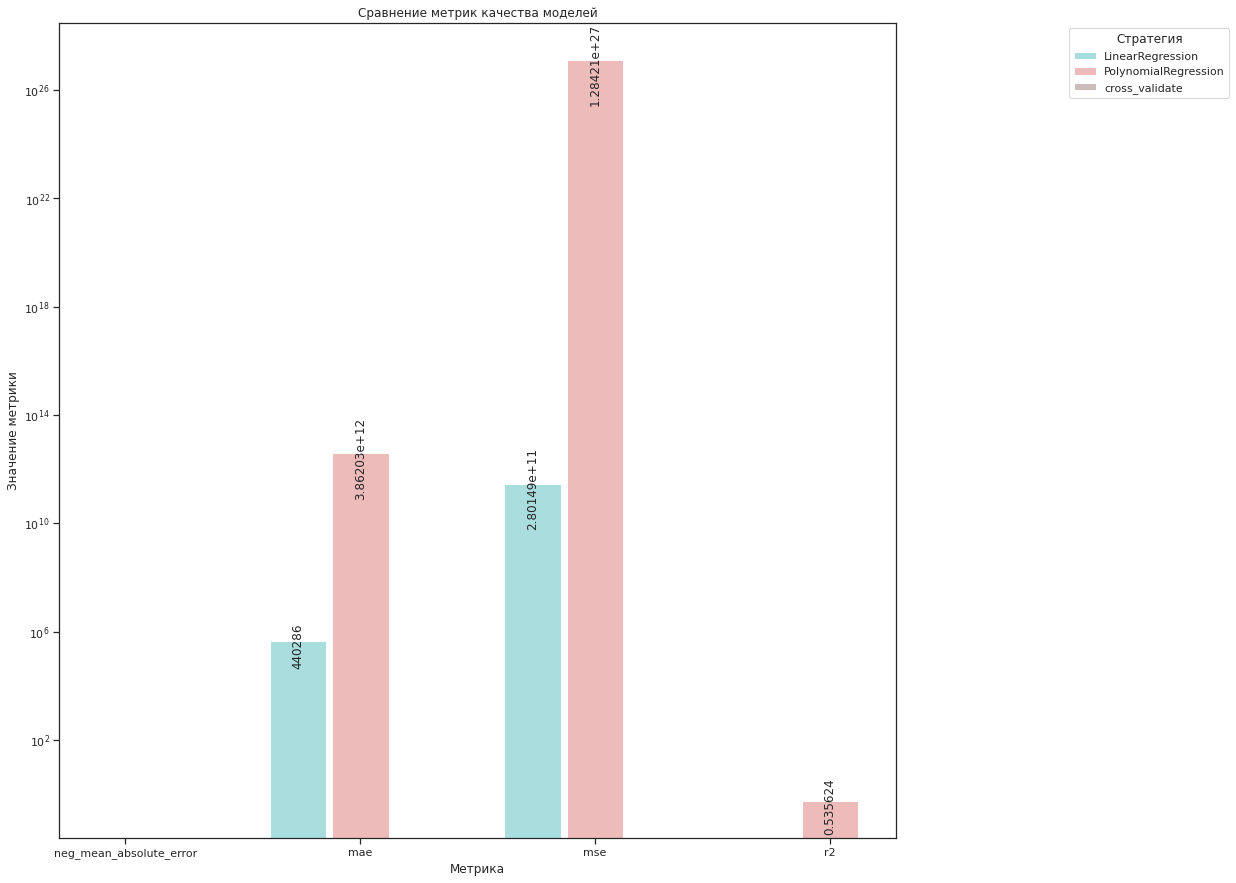

In [37]:
show_metrics_grouped_bar_chart(metrics_data)